### 0. 데이터 확인 및 전처리

In [15]:
import os 
import random 
import cv2
import numpy as np
import matplotlib.pyplot as plt

dir_path = os.getenv('HOME')+'/aiffel/cityscapes/cityscapes'
dir_train =  os.path.join(dir_path, 'train')
dir_val =  os.path.join(dir_path, 'val')

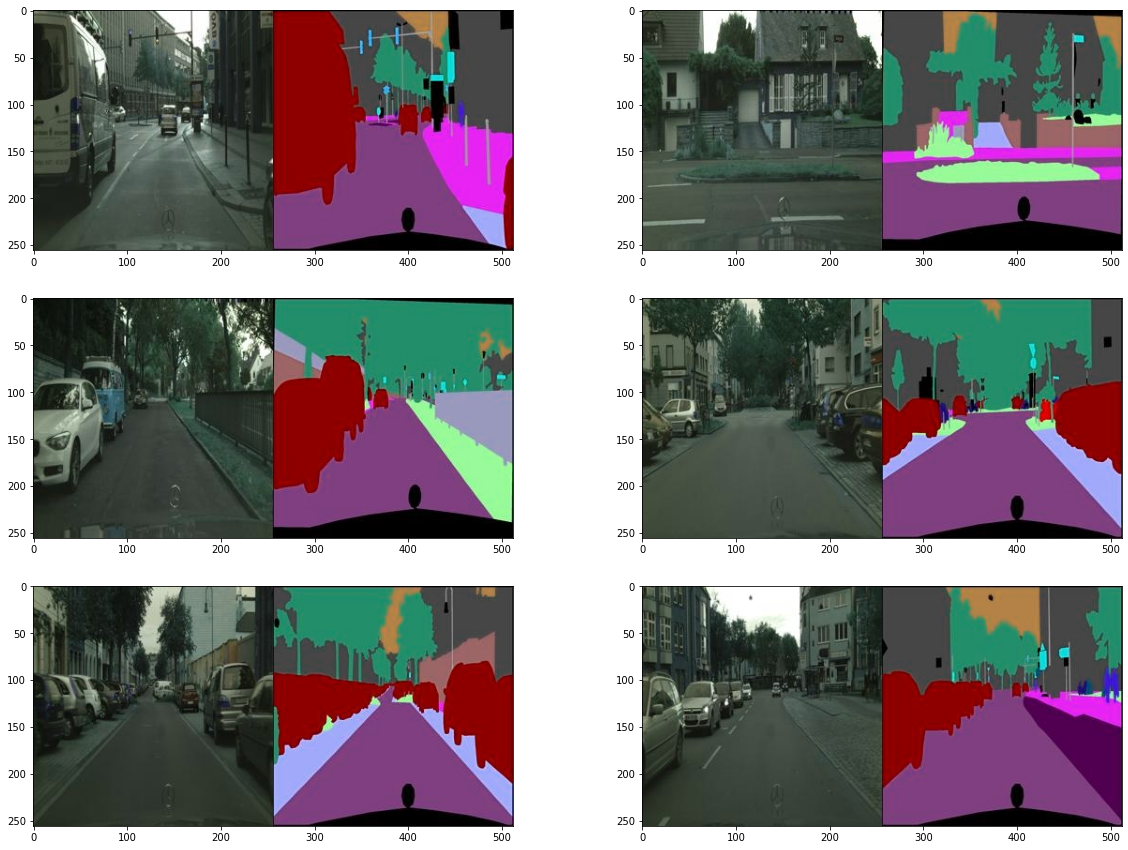

In [28]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = os.path.join(dir_train,os.listdir(dir_train)[np.random.randint(900)])
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [26]:
img.shape

(256, 512, 3)

###### feature_map과 real_map으로 분리

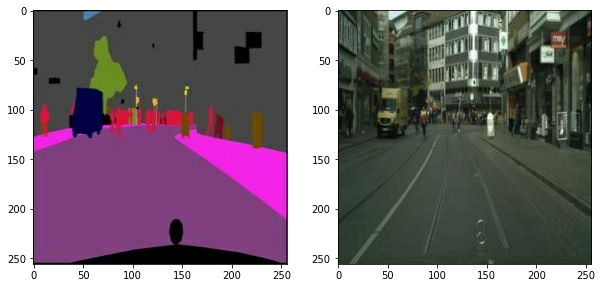

In [33]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    feature_map = img[:, w:, :]
    feature_map = tf.cast(feature_map, tf.float32)
    real_map = img[:, :w, :] 
    real_map = tf.cast(real_map, tf.float32)
    return normalize(feature_map), normalize(real_map)

f = os.path.join(dir_train, os.listdir(dir_train)[1])
feature_map, real_map = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(feature_map))
plt.subplot(1,2,2); plt.imshow(denormalize(real_map))

###### Data Augmentation

In [47]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(feature_map , real_map):
    stacked = tf.concat([feature_map , real_map], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        # ??? Reflect Padding
        padded = tf.pad(stacked, _pad, "REFLECT")
        #print("REFLECT")
        #print("stacked: ", stacked)
        #print("padded: ", padded,'/n')
        
    else:
        # 위아래로 30개씩 '1'로 패딩, 좌우로 30개씩 1로 패딩
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
        #print("CONSTANT")
        #print("stacked: ", stacked)
        #print("padded: ", padded,'/n')
    
    # (316,316,6) 이미지 内에서 (256, 256, 6) 크기만큼 이미지 자르기 
    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    #out = image.random_flip_up_down(out)
    
    #if tf.random.uniform(()) < .5:
    #    degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
    #    out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]  

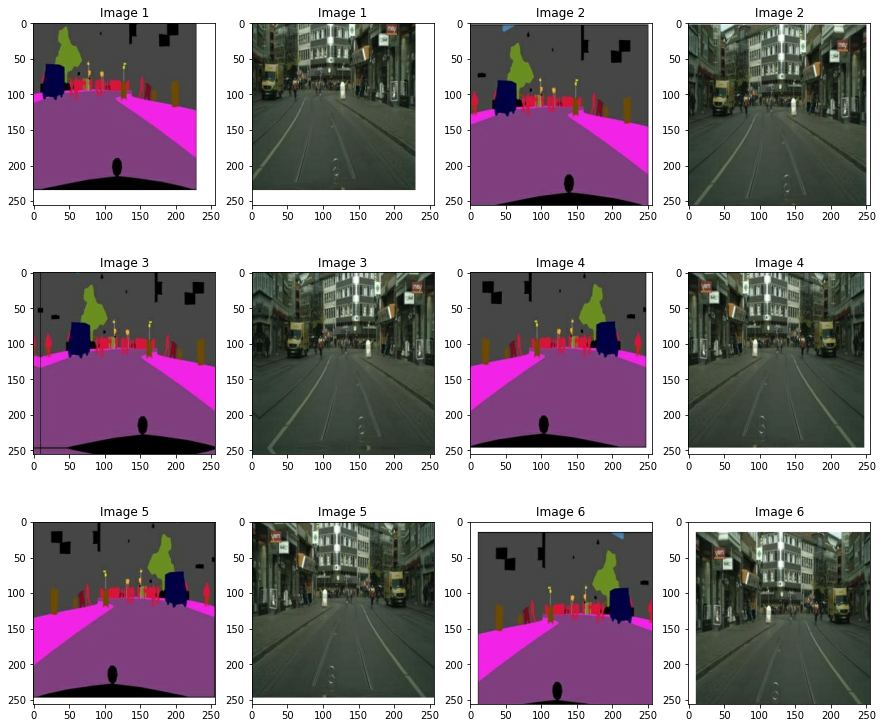

In [48]:
# 위와 같이 구성한 함수를 데이터에 적용해 시각화 해봅시다.

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_feature, augmented_real = apply_augmentation(feature_map, real_map)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_feature)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    img_n += 1

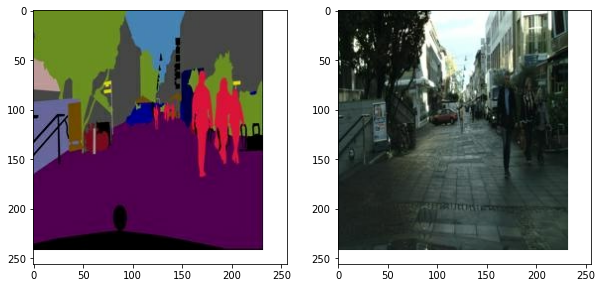

In [51]:
def get_train(img_path):
    feature_map, real_map = load_img(img_path) # Nomalize 적용
    feature_map, real_map = apply_augmentation(feature_map, real_map)
    return feature_map, real_map

train_images = [os.path.join(dir_train, i) for i in os.listdir(dir_train)]
train_images = tf.data.Dataset.from_tensor_slices(train_images)
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator()) # ??? as_numpy_iterator()
feature_map, real_map = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(feature_map[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_map[0].astype(np.uint8))

In [65]:
val_images = [os.path.join(dir_val, i) for i in os.listdir(dir_val)]
val_images = tf.data.Dataset.from_tensor_slices(val_images)
val_images = val_images.map(get_train).shuffle(100).batch(4)

### 1. U-Net Generator 구성하기 

In [53]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [54]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

### 2. Discriminator 구성하기 

In [55]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [56]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [57]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [58]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate[0][0]          

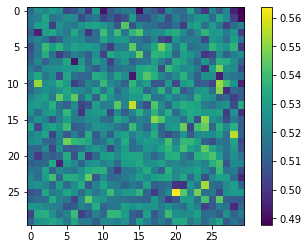

In [59]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 3. 모델 학습

In [60]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [61]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [62]:
@tf.function
def train_step(feature_map, real_map):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_map = generator(feature_map, training=True)
        # Discriminator 예측
        fake_disc = discriminator(feature_map, fake_map, training=True)
        real_disc = discriminator(feature_map, real_map, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_map, real_map, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [63]:
EPOCHS = 10 #약 30분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (feature_map, real_map) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(feature_map, real_map)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8344                     
L1_loss:0.3435                     
Discriminator_loss:1.3557

EPOCH[1] - STEP[20]                     
Generator_loss:0.7916                     
L1_loss:0.2328                     
Discriminator_loss:1.3834

EPOCH[1] - STEP[30]                     
Generator_loss:0.9621                     
L1_loss:0.2035                     
Discriminator_loss:1.3328

EPOCH[1] - STEP[40]                     
Generator_loss:0.7778                     
L1_loss:0.1838                     
Discriminator_loss:1.2609

EPOCH[1] - STEP[50]                     
Generator_loss:1.0338                     
L1_loss:0.1578                     
Discriminator_loss:1.3077

EPOCH[1] - STEP[60]                     
Generator_loss:0.7908                     
L1_loss:0.1730                     
Discriminator_loss:1.3733

EPOCH[1] - STEP[70]                     
Generator_loss:0.8346                     
L1_loss:0.1644                    

## 4. Val 데이터로 테스트

In [68]:
os.listdir(dir_val)

['4.jpg', '1.jpg', '3.jpg', '2.jpg', '5.jpg']

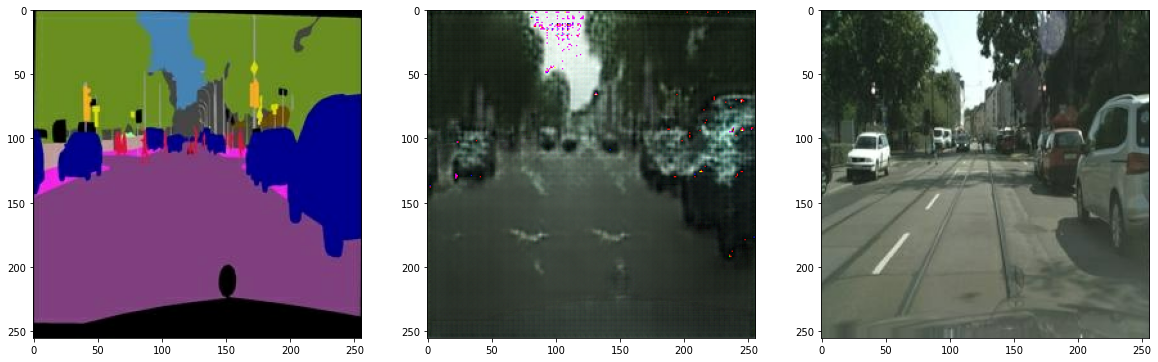

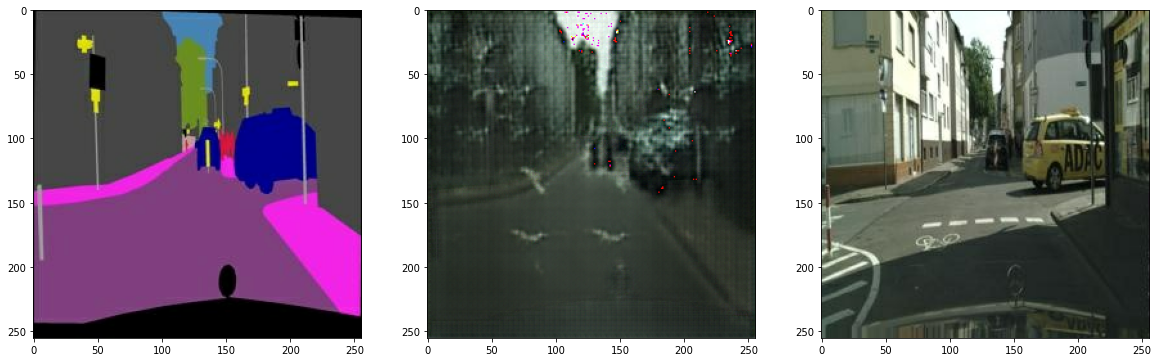

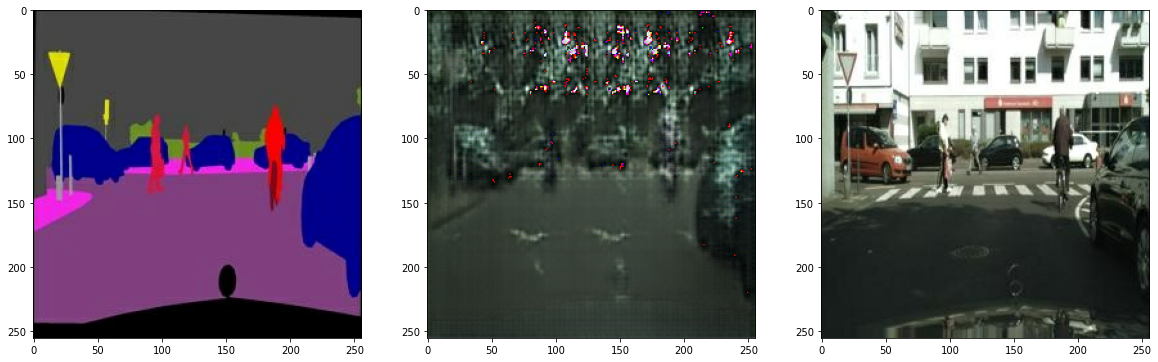

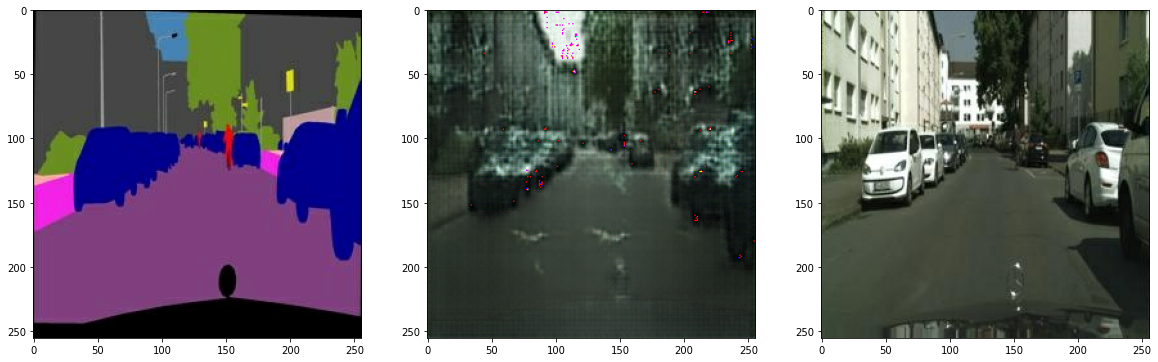

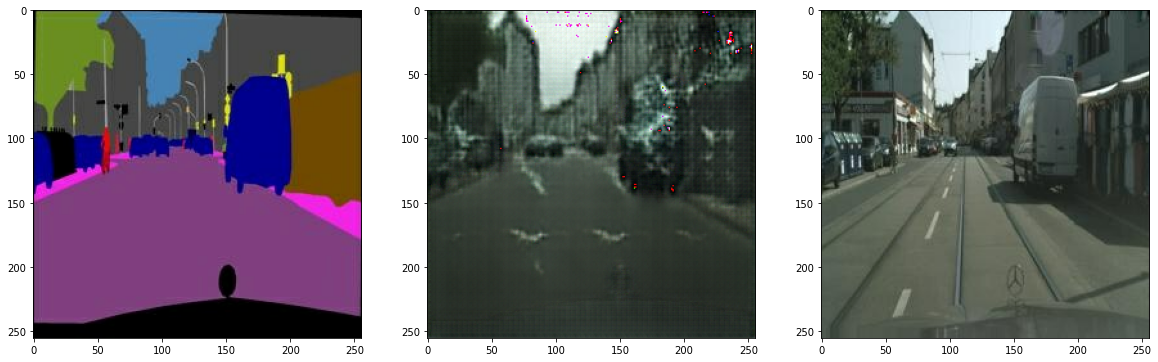

In [71]:
val_list = os.listdir(dir_val)

for i in range(1,6):
    test_ind = i

    f = os.path.join(dir_val, val_list[test_ind-1])
    feature_map, real_map = load_img(f)

    pred = generator(tf.expand_dims(feature_map, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(feature_map))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(real_map))

## 5. 결과 분석 및 고찰

- Data Augmentation 방법으로, 패딩 후 Patch 이미지를 잘라서 해당 이미지의 좌우 대칭을 취하는 방식을 채택하였다. 
- 결과 이미지에 다소 아쉬움이 남는다